In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from math import *
import matplotlib.patches as patches

import cooler
#%matplotlib inline

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray


import cv2


import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [4]:
def fileParser(
    loopfile, 
    layoutfile, 
    lborder, 
    rborder,
    chrom):

    c = cooler.Cooler(loopfile)
    
    known=pd.read_excel(layoutfile)
    known_chr1=known[known['Chr']==chrom]
    
    known_chr1_seg=known_chr1[known_chr1['Genomic bin, Left base']>=lborder]
    known_chr1_seg=known_chr1_seg[known_chr1_seg['Genomic bin, Left base']<=rborder]
    known_chr1_seg=known_chr1_seg[known_chr1_seg['Genomic bin, Right base']>=lborder]
    known_chr1_seg=known_chr1_seg[known_chr1_seg['Genomic bin, Right base']<=rborder]
    
    image=c.matrix(balance=True, sparse=False)[lborder:rborder, lborder:rborder]
    
    return image, known_chr1_seg

# TODO: optional layout, default borders

In [5]:
loopfile='0.2000.cool'
layoutfile='Loop positions_Chr1_Chr6_Chr5.xlsx'

left=0
right=2461
image, known_chr1_seg=fileParser(loopfile, layoutfile, left, right, chrom=1)

In [6]:
def IsDetected(x, y, found):
    for i in range(found.shape[0]):
        xt, yt, rt, xc, yc, thr1, thr2=found[i, :]
        #if ((xt-x)**2+(yt-y)**2 <= rt**2):
        if ((xt-x)**2+(yt-y)**2 <= ceil(rt)**2):
            return True
    return False
    
def IntersectTough(x1, y1, r1, x2, y2, r2):
    if sqrt(((x2-x1)**2+(y2-y1)**2))<(max(r1, r2)+2):
        return True
    else:
        return False
        
def IntersectEasy(x1, y1, r1, x2, y2, r2):
    if sqrt(((x2-x1)**2+(y2-y1)**2))<(r1+r2+1):
        return True
    else:
        return False        

In [7]:
def GetCenter(
    image, 
    x, y, 
    r):
    tmp=image[int(x-floor(r)):int(x+floor(r)), int(y-floor(r)):int(y+floor(r))]
    if tmp.size==0:
        return np.array([np.nan, np.nan])
    res=np.unravel_index(tmp.argmax(), tmp.shape)
    return np.array([int(x-floor(r))+res[0], int(y-floor(r))+res[1]])
    
def DiagonalFilter(
    image, 
    x, y, 
    r):
    for i in range(image.shape[0]):
        if (((i-x-0.5+2)**2+(i-y-0.5)**2)<=r**2) or (((i-x-0.5+2)**2+(i-y-0.5+1)**2)<=r**2):
            return False
    return True

In [8]:
def BarbekuFinderFrameLog(
    whole_image,
    left, right, 
    k=3, 
    frame=7, 
    min_sigma=3,
    max_sigma=10,
    num_sigma=10,
    sigmaX=7, 
    thresh=0.5, 
    thresh2=60):
    
    #image, known_chr1_seg=fileParser(loopfile, layoutfile, left, right)
    image=whole_image[left:right, left:right]

    image=image/np.max(image)*255
    real=image.shape[0]
    enlarged=np.zeros((real*k, real*k))
    for i in range(real*k):
        for j in range(real*k):
            enlarged[i, j]=image[i//k, j//k]
    blur=cv2.GaussianBlur(enlarged, (frame,frame), sigmaX)
    blur=blur/np.max(blur)*255
    blobs_log = blob_log(blur, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold=0.001)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    detected=[]
    res=[]
    
    for i in range(blobs_log.shape[0]):
        y, x, r = blobs_log[i,:]
        if  (x>y) and DiagonalFilter(image, x//k, y//k, r/k):
        #if (x>y):
            detected.append([x//k, y//k, r/k])
            xc, yc=GetCenter(image, detected[-1][0], detected[-1][1], detected[-1][2])
            if not(np.isnan(xc)):
                #if image[xc, yc]>np.mean(image):
                #if image[xc,yc]>thresh:
                test_thresh=np.sum(image[int(x//k-floor(r/k))-1:int(x//k+floor(r/k))+1, int(y//k-floor(r/k))-1:int(y//k+floor(r/k))+1])-np.sum(image[int(x//k-floor(r/k)):int(x//k+floor(r/k)), int(y//k-floor(r/k)):int(y//k+floor(r/k))])
                test_num=(int(x//k+floor(r/k))-int(x//k-floor(r/k))+2)*(int(y//k+floor(r/k))-int(y//k-floor(r/k))+2)-(int(x//k+floor(r/k))-int(x//k-floor(r/k)))*(int(y//k+floor(r/k))-int(y//k-floor(r/k)))
                test_thresh=test_thresh/test_num
                if ((image[xc,yc]-test_thresh)/test_thresh>thresh) and (image[xc, yc]>thresh2):
                    res.append([x//k, y//k, r/k, xc, yc, (image[xc,yc]-test_thresh)/test_thresh, image[xc, yc]])
                    #print(image[xc,yc], test_thresh, test_num)
    return np.array(res)


In [15]:
loopfile='0.2000.cool'
layoutfile='Loop positions_Chr1_Chr6_Chr5.xlsx'

left=15173
right=16974
image, known_chr1_seg=fileParser(loopfile, layoutfile, left, right, chrom=6)


found=[]
for step in range(0, right-left-30, 1):
    found_tmp=BarbekuFinderFrameLog(frame=7, whole_image=image, left=step, right=step+30, k=5, thresh=1.0, thresh2=65, min_sigma=0.1, max_sigma=4, num_sigma=15)
    for count in range(found_tmp.shape[0]):
        x, y, r, xc, yc, thr1, thr2 = found_tmp[count,:]
        found.append([x+step, y+step, r, xc+step, yc+step, thr1, thr2])
    print(step, end=' ')
    

found=np.array(found)    
st=0
for i in range(known_chr1_seg.shape[0]):
    if IsDetected(known_chr1_seg['Genomic bin, Right base'][i]-1, known_chr1_seg['Genomic bin, Left base'][i]-1, found):
        continue
    else:
        st+=1
print(st, '/', known_chr1_seg.shape[0], '/', found.shape[0])

np.savetxt('brbq2-0.1_4_15.chr6', found, delimiter=',')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [50]:
fl=np.ones(found.shape[0])
sum=0
for i in range(found.shape[0]):
    if fl[i]==0:
        continue
    intersect=[]
    intersect.append(i)
    for j in range(i+1, found.shape[0], 1):
        for tmp in intersect: 
            if IntersectTough(found[tmp, 0], found[tmp, 1], found[tmp, 2], found[j, 0], found[j, 1], found[j, 2]) and (fl[j]==1):
                intersect.append(j)
                #print(j, end=' ')
                break
    #print(len(intersect), end=' ')
    #print(i, end=' ')
    sum+=len(intersect)-1
    print(sum, end=' ')
    if len(intersect)==1:
        continue
    maxes=[]
    for tmp in intersect:
        #xc, yc=GetCenter(image, found[tmp, 0], found[tmp, 1], found[tmp, 2])
        #print(xc, yc)
        maxes.append(found[tmp, 6])
    max_pos=np.argmax(np.array(maxes))
    for j in range(len(intersect)):
        if j!=max_pos:
            fl[intersect[j]]=0
            
print(np.sum(fl))

0 0 1 19 19 30 30 30 30 31 31 31 32 33 33 52 52 64 64 77 78 78 78 100 100 101 101 102 102 103 103 104 104 105 105 105 113 113 115 115 115 115 129 129 150 151 151 151 151 158 158 158 159 159 159 159 162 162 183 183 183 183 184 184 184 184 184 184 184 184 185 186 186 186 186 186 186 187 187 187 188 188 189 189 198 200 200 218 220 220 220 221 221 221 221 226 226 245 247 247 247 262 270 270 286 286 288 288 289 289 291 291 291 302 302 302 302 324 324 324 341 341 341 342 343 343 347 347 347 347 349 349 349 349 350 372 372 372 372 372 380 381 395 395 395 396 396 397 397 399 399 422 422 422 423 423 438 438 438 439 439 455 458 458 458 474 474 494 494 497 497 498 498 502 502 520 520 520 548 548 549 549 550 550 553 574 593 593 593 593 594 594 594 595 596 596 596 596 596 597 630 630 631 631 642 659 659 659 660 660 660 660 660 661 662 662 662 662 663 663 664 666 666 666 666 667 668 668 669 669 669 669 670 670 671 671 671 671 671 694 713 715 715 715 715 715 715 731 731 733 733 735 736 736 737 739 73

In [51]:
left=0
right=2461
image, known_chr1_seg=fileParser(loopfile, layoutfile, left, right)


filtered=found[fl.astype(bool),:]

st=0
for i in range(known_chr1_seg.shape[0]):
    if IsDetected(known_chr1_seg['Genomic bin, Right base'][i]-1, known_chr1_seg['Genomic bin, Left base'][i]-1, filtered):
        continue
    else:
        st+=1

print(st, '/', known_chr1_seg.shape[0], '/', filtered.shape[0])
print('Sensitivity: ', 1-st/known_chr1_seg.shape[0])
print('FDR: ', (filtered.shape[0]+st-known_chr1_seg.shape[0])/filtered.shape[0])

38 / 148 / 227
Sensitivity:  0.7432432432432432
FDR:  0.5154185022026432


In [52]:
#    found_tmp=BarbekuFinderFrameLog(frame=7, whole_image=image, left=left+step, right=left+step+30, k=5, thresh=1.0, thresh2=65, min_sigma=0.5, max_sigma=7, num_sigma=15)
# 73 52
#     found_tmp=BarbekuFinderFrameLog(frame=7, whole_image=image, left=left+step, right=left+step+30, k=5, thresh=1.0, thresh2=65, min_sigma=0.1, max_sigma=4, num_sigma=15)
# 78 52

In [55]:
def BarbekuFinderFrameDraw(
    loopfile, 
    layoutfile, 
    left, right, 
    k=3, 
    frame=7, 
    sigmaX=7,
    min_sigma=3,
    max_sigma=10,
    thresh=0.5, 
    thresh2=60):
    
    image, known_chr1_seg=fileParser(loopfile, layoutfile, left, right)
    image=image/np.max(image)*255
    real=image.shape[0]
    enlarged=np.zeros((real*k, real*k))
    for i in range(real*k):
        for j in range(real*k):
            enlarged[i, j]=image[i//k, j//k]
    blur=cv2.GaussianBlur(enlarged, (frame,frame), sigmaX)
    blur=blur/np.max(blur)*255
    blobs_log = blob_log(blur, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=1000, threshold=0.001)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    detected=[]

    fig=plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='YlOrRd')
    for i in range(blobs_log.shape[0]):
        y, x, r = blobs_log[i,:]
        if  (x>y) and DiagonalFilter(image, x//k, y//k, r/k):
        #if (x>y):
            detected.append([x//k, y//k, r/k])
            xc, yc=GetCenter(image, detected[-1][0], detected[-1][1], detected[-1][2])
            if not(np.isnan(xc)):
                test_thresh=np.sum(image[int(x//k-floor(r/k))-1:int(x//k+floor(r/k))+1, int(y//k-floor(r/k))-1:int(y//k+floor(r/k))+1])-np.sum(image[int(x//k-floor(r/k)):int(x//k+floor(r/k)), int(y//k-floor(r/k)):int(y//k+floor(r/k))])
                test_num=(int(x//k+floor(r/k))-int(x//k-floor(r/k))+2)*(int(y//k+floor(r/k))-int(y//k-floor(r/k))+2)-(int(x//k+floor(r/k))-int(x//k-floor(r/k)))*(int(y//k+floor(r/k))-int(y//k-floor(r/k)))
                test_thresh=test_thresh/test_num
                if ((image[xc,yc]-test_thresh)/test_thresh>thresh) and (image[xc, yc]>thresh2):
                #if image[xc, yc]>np.mean(image):
                #if image[xc,yc]>thresh:
                    print(x//k, y//k, r/k, '|||', xc, yc, ':::', image[xc,yc])
                    c = plt.Circle((x//k, y//k), r/k, color='black', linewidth=2, fill=False)
                    ax.plot(x//k, y//k, 'ko')
                    ax.add_patch(c)
                    ax.plot(xc, yc, 'bs')
    print(np.mean(image))
    ax.set_axis_off()
    ax.plot((known_chr1_seg['Genomic bin, Right base']-left-1), (known_chr1_seg['Genomic bin, Left base']-left-1), 'go')
    plt.show()

        NOT FOUND:    271.0 267.0
29.0 22.0 1.4142135623730951 ||| 29 22 ::: 85.75434878503607
19.0 15.0 1.0956969942710466 ||| 19 15 ::: 102.70286318814834
21.0 10.0 1.4142135623730951 ||| 21 10 ::: 67.2737303144213
34.88169626131103


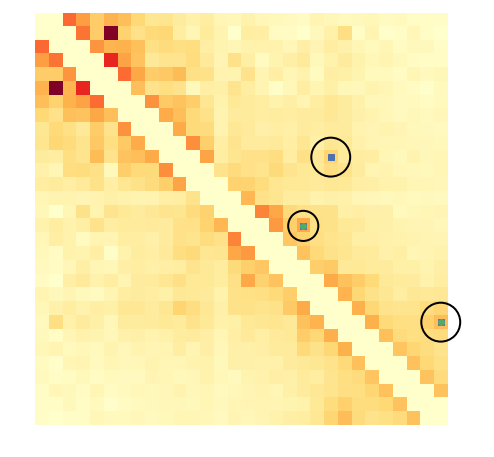

        NOT FOUND:    458.0 452.0
16.0 8.0 1.4142135623730951 ||| 15 8 ::: 153.42821380440282
59.98012323475459


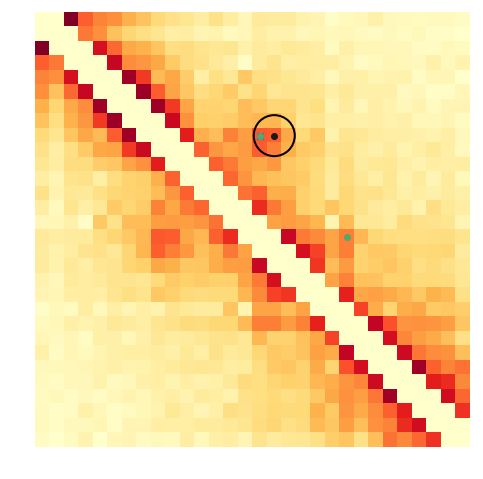

        NOT FOUND:    518.0 513.0
29.0 22.0 1.4142135623730951 ||| 29 21 ::: 150.42528812393564
16.0 6.0 1.4142135623730951 ||| 16 6 ::: 176.92521473183623
16.0 4.0 1.2371183505083563 ||| 16 4 ::: 106.73634181726895
52.30482263053324


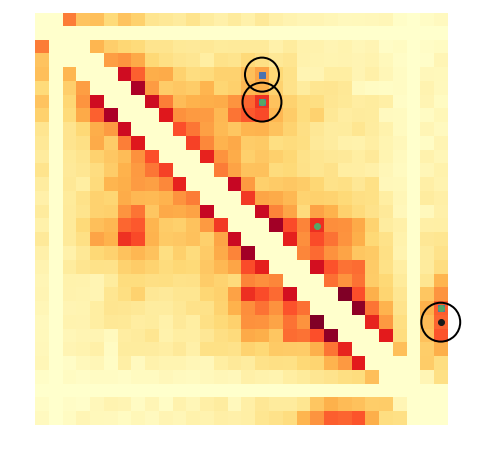

        NOT FOUND:    533.0 527.0
25.0 15.0 1.4142135623730951 ||| 25 15 ::: 89.90128211589372
15.0 8.0 1.4142135623730951 ||| 15 7 ::: 102.65963326323295
6.0 2.0 1.4142135623730951 ||| 6 1 ::: 121.37978630098374
42.107100525031285


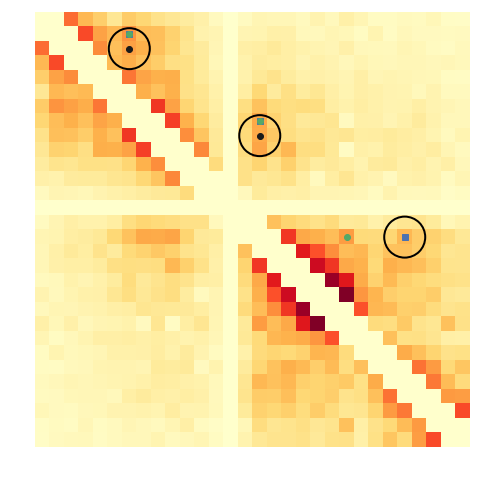

        NOT FOUND:    569.0 552.0
14.0 6.0 1.3071919954908071 ||| 13 6 ::: 76.46514239676773
41.50161764848888


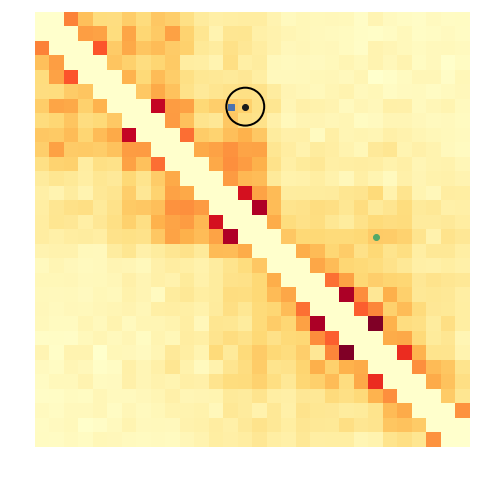

        NOT FOUND:    605.0 598.0
23.0 15.0 1.1262745848088433 ||| 22 15 ::: 93.879109164516
22.0 11.0 1.4142135623730951 ||| 21 11 ::: 67.53791598722665
46.6905242728636


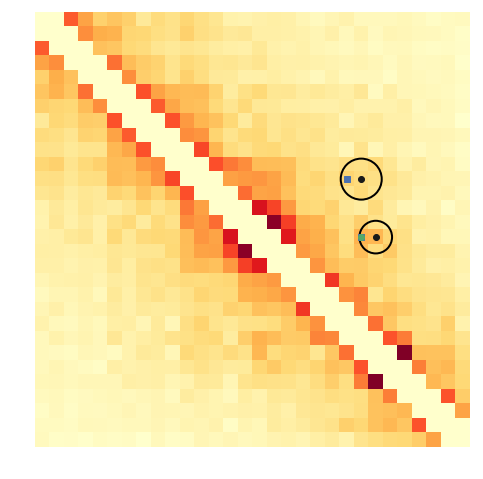

        NOT FOUND:    731.0 725.0
12.0 8.0 1.3377695860286036 ||| 12 8 ::: 97.34624305911893
12.0 3.0 1.4142135623730951 ||| 12 3 ::: 107.11635459837825
39.97138861308882


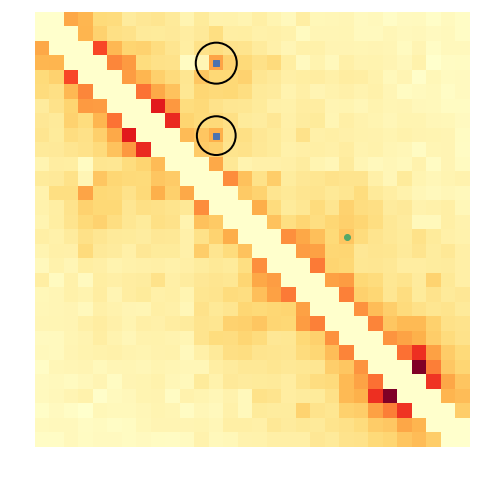

        NOT FOUND:    741.0 733.0
38.26563377731556


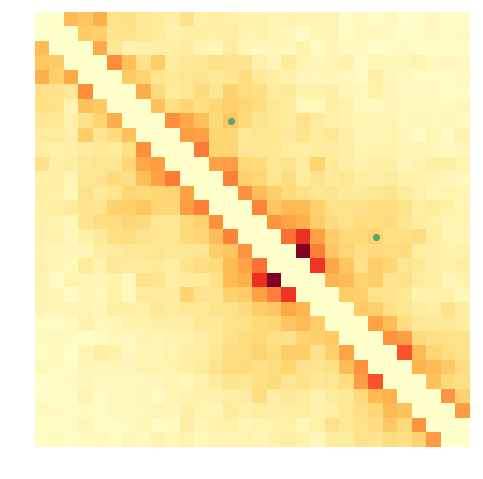

        NOT FOUND:    763.0 756.0


KeyboardInterrupt: 

In [56]:
ran=15 #uncertinty range


chk=(-1)*np.ones(filtered.shape[0])
for i in range(known_chr1_seg.shape[0]):
    xtest=known_chr1_seg['Genomic bin, Right base'][i]-1
    ytest=known_chr1_seg['Genomic bin, Left base'][i]-1
    for j in range(filtered.shape[0]):
        if ((xtest-filtered[j,0])**2+(ytest-filtered[j,1])**2 <= ceil(filtered[j,2])**2):
            if chk[j]!=(-1):
                print('SHIT')
            else:
                chk[j]=i
unmapped=filtered[chk==-1, :]
mapped=filtered[chk!=-1,:]

for i in range(filtered.shape[0]):
    if chk[i]==-1:
        for j in range(len(cross)):
            if abs(filtered[i, 0]-cross[j])<=ran:
                chk[i]=-2
                
filtered_crossed=filtered[chk!=-2, :]

st=0
for i in range(known_chr1_seg.shape[0]):
    if IsDetected(known_chr1_seg['Genomic bin, Right base'][i]-1, known_chr1_seg['Genomic bin, Left base'][i]-1, filtered_crossed):
        continue
    else:
        st+=1
        l1=int(max(known_chr1_seg['Genomic bin, Left base'][i]-1-15, 0))
        r1=l1+30
        print('        NOT FOUND:   ', known_chr1_seg['Genomic bin, Right base'][i]-1, known_chr1_seg['Genomic bin, Left base'][i]-1)
        BarbekuFinderFrameDraw(loopfile=loopfile, layoutfile=layoutfile, left=l1, right=r1, k=5, thresh=0.5, thresh2=60, min_sigma=0.5, max_sigma=5)

print(st, '/', known_chr1_seg.shape[0], '/', filtered_crossed.shape[0])
print('Sensitivity: ', 1-st/known_chr1_seg.shape[0])
print('FDR: ', (filtered_crossed.shape[0]+st-known_chr1_seg.shape[0])/filtered_crossed.shape[0])